# Imports

## Pakages

In [1]:
# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
import os, datetime, copy
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import tensorflow as tf

# Models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, metrics, losses
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
tf.__version__

'2.10.0'

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Notebook Config

In [4]:
class cfg:
    base_dir = os.getcwd()
    data_dir = f'{base_dir}\\Data\\1.xlsx'
    is_validation_phase = True
    color = sns.color_palette()
    split_date = 2018
    country = 'brazil'
    window_size = 5

## Importing Data

In [5]:
df = pd.read_excel(cfg.data_dir, header=1)
df.head()

,سال,iran,india,china,usa,russia,saudi,japan,south k,germany,indo,brazil
0,1981,113.00,314.97,1480,4690.0,2090,175.30,926.84,139.59,1050.0,100.30,170.61
1,1982,137.77,325.38,1610,4450.0,2130,157.89,897.41,140.78,1020.0,105.58,170.81
2,1983,149.58,352.20,1690,4430.0,2160,160.84,880.91,149.13,1010.0,105.18,165.35
3,1984,149.86,361.56,1840,4660.0,2180,155.51,937.07,160.70,1030.0,112.46,167.08
4,1985,159.86,397.59,2000,4650.0,2350,172.42,912.40,168.76,1040.0,121.60,179.59


In [6]:
df = df[['سال', cfg.country]]
for col in ['china', 'usa', 'japan', 'russia']:
    if cfg.country == col:
        df[col] = df[col]*1000
df.head()

,سال,brazil
0,1981,170.61
1,1982,170.81
2,1983,165.35
3,1984,167.08
4,1985,179.59


In [7]:
df.dtypes

سال         int64
brazil    float64
dtype: object

In [8]:
grouped_df = df.copy()
grouped_df = grouped_df.rename(columns={'سال':'year'})
grouped_df = grouped_df.set_index('year')
featured_df = pd.DataFrame()
for col in df.columns[1:]:
    temp = np.stack([df['سال'].values,
                     np.array([col]*df.shape[0]),
                     df[col].values],
                     axis=1)
    temp = pd.DataFrame(temp)
    
    featured_df = featured_df.append(temp, ignore_index=True)
featured_df.columns = ['year', 'country', 'emission']
featured_df = featured_df.sort_values(['year', 'country'])
featured_df.index = range(featured_df.shape[0])
featured_df['year'] = featured_df['year'].astype('int')
featured_df['emission'] = featured_df['emission'].astype('float')

C:\Users\Amirhossein\AppData\Local\Temp\ipykernel_15216\1309968135.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  featured_df = featured_df.append(temp, ignore_index=True)


In [9]:
featured_df.head()

,year,country,emission
0,1981,brazil,170.61
1,1982,brazil,170.81
2,1983,brazil,165.35
3,1984,brazil,167.08
4,1985,brazil,179.59


## Preprocess

In [10]:
ct = ColumnTransformer([('cat', OneHotEncoder(), ['country'])], remainder='passthrough', sparse_threshold=0)

prep_pipe = Pipeline([
    ('ct', ct),
])

prep_pipe.fit(featured_df.iloc[:,:-1])

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['country'])]))])

# Models For Featured Data

## Train/Val Split

In [11]:
if cfg.is_validation_phase:
    ds_train_f = featured_df.loc[featured_df.year<cfg.split_date]
    x_train_f = ds_train_f.iloc[:,:-1]
    x_train_f = prep_pipe.transform(x_train_f)
    y_train_f = ds_train_f.iloc[:,-1].values
    
    ds_val_f = featured_df.loc[featured_df.year>=cfg.split_date]
    x_val_f = ds_val_f.iloc[:,:-1]
    x_val_f = prep_pipe.transform(x_val_f)
    y_val_f = ds_val_f.iloc[:,-1]
    
else:
    ds_train_f = featured_df
    x_train_f = ds_train_f.iloc[:,:-1]
    x_train_f = prep_pipe.transform(x_train_f)
    y_train_f = ds_train_f.iloc[:,-1].values
    

In [12]:
x_train_f.shape

(37, 2)

## Regression

In [13]:
# model config
if cfg.is_validation_phase:
    eval_set = [(x_train_f, y_train_f), (x_val_f, y_val_f)]
else:
    eval_set = [(x_train_f, y_train_f)]

REG_model = LinearRegression()

In [14]:
REG_model.fit(x_train_f, y_train_f)

LinearRegression()

In [15]:
REG_pipe = Pipeline([
    ('preprocess', prep_pipe),
    ('REG', REG_model)
])

In [16]:
pred_all = REG_pipe.predict(featured_df)
pred_train = REG_model.predict(x_train_f)
if cfg.is_validation_phase:
    pred_val = REG_model.predict(x_val_f)

if cfg.is_validation_phase:
    pred = {'all':pred_all, 'train':pred_train, 'val':pred_val}
    y_true = {'all':featured_df.emission.values, 'train':y_train_f, 'val':y_val_f}
else:
    pred = {'all':pred_all, 'train':pred_train}
    y_true = {'all':featured_df.emission.values, 'train':y_train_f}

results_metrics = pd.DataFrame()
results_metrics['r2_score'] = [r2_score(y_true[i], pred[i]) for i in pred]
results_metrics['mae'] = [mean_absolute_error(y_true[i], pred[i]) for i in pred]
results_metrics['mse'] = [mean_squared_error(y_true[i], pred[i]) for i in pred]
results_metrics['rmse'] = [np.sqrt(mean_squared_error(y_true[i], pred[i])) for i in pred]
results_metrics.index = [i for i in pred]

In [17]:
results_metrics

,r2_score,mae,mse,rmse
all,0.924518,22.687648,1070.013380,32.711059
train,0.959917,17.133933,545.641560,23.358972
val,-18.788643,74.059520,5920.452708,76.944478


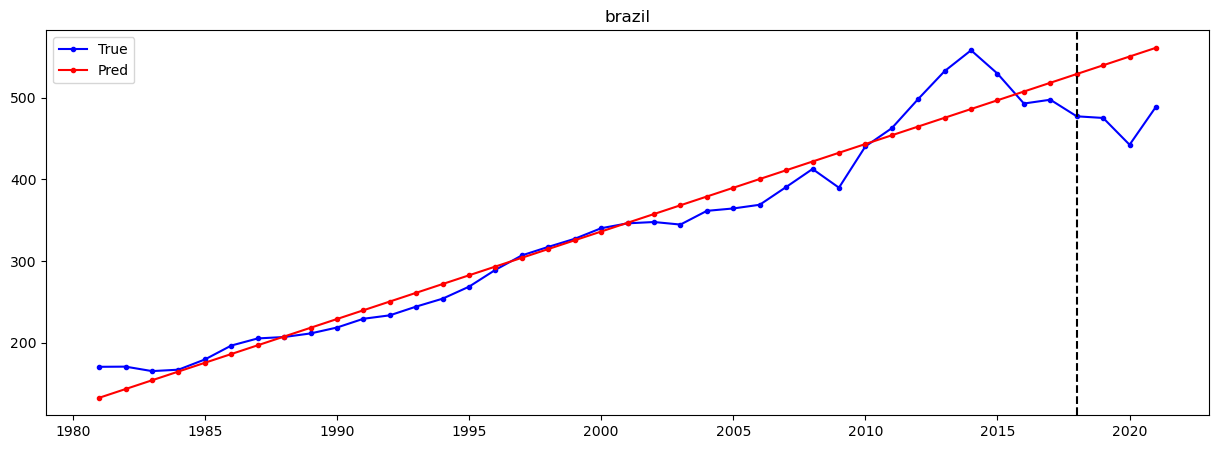

In [18]:
for col in df.columns[1:]:
    data = featured_df.loc[featured_df.country==col]
    a = REG_pipe.predict(data.iloc[:,:-1])
    plt.figure(figsize=(15,5))
    plt.title(col)
    plt.plot(data.year, data.emission, color='b', marker='.')
    plt.plot(data.year, a, color='r', marker='.')
    if cfg.is_validation_phase:
        plt.axvline(x=cfg.split_date, color='black', ls='--')
    plt.legend(['True', 'Pred'])
    plt.show()

# Models for Time-Series Data

## Train/Val Split

In [19]:
window_size = 10

In [20]:
temp_ds = tf.data.Dataset.from_tensor_slices(grouped_df.values)
temp_ds = temp_ds.window(size=window_size, drop_remainder=True, shift=1)
temp_ds = temp_ds.flat_map(lambda window: window.batch(window_size))
temp_ds = temp_ds.map(lambda window: (window[:-1], window[-1]))

feat = []
labels = []
for x,y in temp_ds:
    feat.append(x.numpy())
    labels.append(y.numpy())
feat = np.array(feat)
labels = np.array(labels)
idx = df.loc[grouped_df.index == cfg.split_date].index.values-df.shape[0]

In [21]:
if cfg.is_validation_phase:
    x_train_ts = feat[:idx[0]].reshape(-1, window_size-1)
    y_train_ts = labels[:idx[0]]

    x_val_ts = feat[idx[0]:].reshape(-1, window_size-1)
    y_val_ts = labels[idx[0]:]
else:
    x_train_ts = feat.reshape(-1, window_size-1)
    y_train_ts = labels

In [22]:
x_train_ts.shape, y_train_ts.shape

((28, 9), (28, 1))

## LSTM NN

In [31]:
# config
tf.keras.backend.clear_session()

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=50,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

if cfg.is_validation_phase:
    validation_data = (x_val_ts, y_val_ts)
else:
    validation_data = None

# model
LSTM_model = Sequential([
    layers.LSTM(16, return_sequences=False, input_shape=(window_size-1,1), activation='relu'),
    #layers.LSTM(64, return_sequences=False, activation='relu'),
    #layers.Dense(4, activation='relu'),
    layers.Dense(1, activation='linear'),
])



In [32]:
LSTM_model.compile(loss='mse', optimizer=optimizers.Adam(0.01), metrics=['mean_absolute_error'])

In [33]:

history = LSTM_model.fit(x_train_ts, y_train_ts, 
                        validation_data =validation_data, 
                        epochs=5000, 
                        callbacks=[es]
                       )

Epoch 1/5000
1/1 [==============================] - 1s 1s/step - loss: 165162.6094 - mean_absolute_error: 392.8071 - val_loss: 243474.2031 - val_mean_absolute_error: 493.1436
Epoch 2/5000
1/1 [==============================] - 0s 63ms/step - loss: 158017.2812 - mean_absolute_error: 383.2876 - val_loss: 141266.3125 - val_mean_absolute_error: 375.4479
Epoch 3/5000
1/1 [==============================] - 0s 57ms/step - loss: 107262.9219 - mean_absolute_error: 316.6160 - val_loss: 109279.3125 - val_mean_absolute_error: 330.0916
Epoch 4/5000
1/1 [==============================] - 0s 54ms/step - loss: 88025.0781 - mean_absolute_error: 286.7414 - val_loss: 83335.6719 - val_mean_absolute_error: 288.1049
Epoch 5/5000
1/1 [==============================] - 0s 76ms/step - loss: 72407.6953 - mean_absolute_error: 259.8779 - val_loss: 58150.9453 - val_mean_absolute_error: 240.4247
Epoch 6/5000
1/1 [==============================] - 0s 72ms/step - loss: 56793.9805 - mean_absolute_error: 229.9547 - val

1/1 [==============================] - 0s 54ms/step - loss: 885.5146 - mean_absolute_error: 24.0215 - val_loss: 13519.1289 - val_mean_absolute_error: 113.5812
Epoch 49/5000
1/1 [==============================] - 0s 52ms/step - loss: 784.4166 - mean_absolute_error: 22.9929 - val_loss: 15005.9883 - val_mean_absolute_error: 119.9728
Epoch 50/5000
1/1 [==============================] - 0s 54ms/step - loss: 730.8740 - mean_absolute_error: 22.1003 - val_loss: 16791.5059 - val_mean_absolute_error: 127.1841
Epoch 51/5000
1/1 [==============================] - 0s 58ms/step - loss: 737.9785 - mean_absolute_error: 21.2260 - val_loss: 18404.1543 - val_mean_absolute_error: 133.3616
Epoch 52/5000
1/1 [==============================] - 0s 57ms/step - loss: 797.6845 - mean_absolute_error: 21.1030 - val_loss: 19696.3125 - val_mean_absolute_error: 138.1122
Epoch 53/5000
1/1 [==============================] - 0s 56ms/step - loss: 868.8271 - mean_absolute_error: 21.5079 - val_loss: 20530.1992 - val_mean_a

In [34]:
pred_all = LSTM_model.predict(feat.reshape(-1, window_size-1))
pred_train = LSTM_model.predict(x_train_ts)
if cfg.is_validation_phase:
    pred_val = LSTM_model.predict(x_val_ts)
if cfg.is_validation_phase:
    pred = {'all':pred_all, 'train':pred_train, 'val':pred_val}
    y_true = {'all':labels, 'train':y_train_ts, 'val':y_val_ts}
else: 
    pred = {'all':pred_all, 'train':pred_train}
    y_true = {'all':labels, 'train':y_train_ts}
results_metrics = pd.DataFrame()
results_metrics['r2_score'] = [r2_score(y_true[i], pred[i]) for i in pred]
results_metrics['mae'] = [mean_absolute_error(y_true[i], pred[i]) for i in pred]
results_metrics['mse'] = [mean_squared_error(y_true[i], pred[i]) for i in pred]
results_metrics['rmse'] = [np.sqrt(mean_squared_error(y_true[i], pred[i])) for i in pred]
results_metrics.index = [i for i in pred]

1/1 [==============================] - 0s 25ms/step


In [35]:
results_metrics

,r2_score,mae,mse,rmse
all,-0.218761,99.158620,11661.438210,107.988139
train,-0.359223,108.261681,13085.770098,114.393051
val,-4.644543,35.421588,1688.758957,41.094512


1/1 [==============================] - 0s 24ms/step


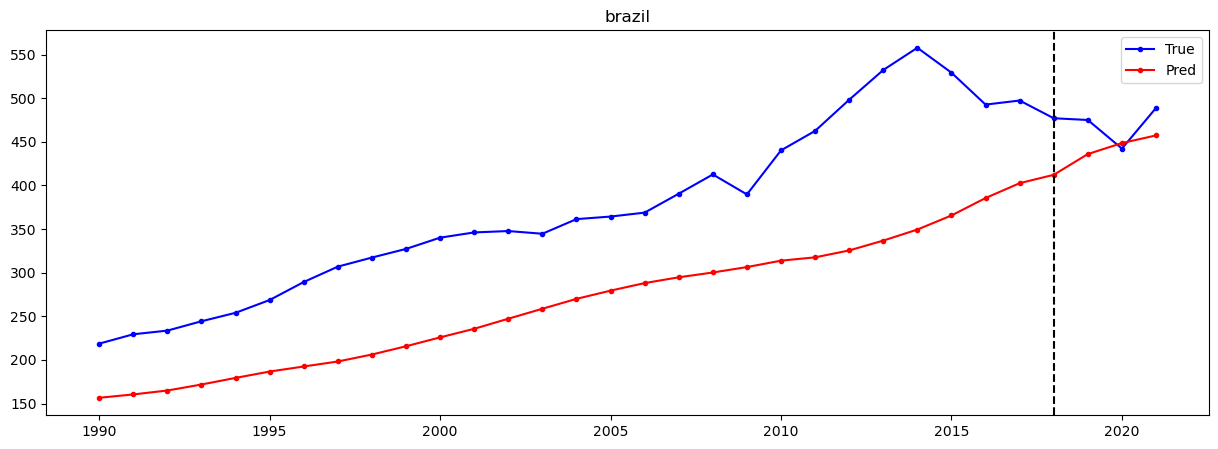

In [36]:
for col in df.columns[1:]:
    data = featured_df.loc[featured_df.country==col]
    a = LSTM_model.predict(feat.reshape(-1, window_size-1))
    plt.figure(figsize=(15,5))
    plt.title(col)
    plt.plot(data.year.iloc[-labels.shape[0]:], labels, color='b', marker='.')
    plt.plot(data.year.iloc[-labels.shape[0]:], a, color='r', marker='.')
    if cfg.is_validation_phase:
        plt.axvline(x=cfg.split_date, color='black', ls='--')
    plt.legend(['True', 'Pred'])
    plt.show()

In [29]:
#LSTM_model.save(f'models/LSTM_{cfg.country}')

# Inference

In [30]:
last = feat.reshape(-1, window_size-1)[-1]
last = np.expand_dims(last, axis=0)

In [31]:
inf = []
for i in range(10):
    p = LSTM_model.predict(last)
    last = np.expand_dims(np.append(last[:,1:], p),axis=0)
    #print(last)
    inf.append(p[0,0])

1/1 [==============================] - 0s 24ms/step


In [32]:
inf

[1029271.6,
 999169.2,
 970017.2,
 941895.44,
 914468.0,
 887797.56,
 861821.5,
 836329.2,
 811867.06,
 788309.9]

In [33]:
LSTM_model.predict(last)

1/1 [==============================] - 0s 26ms/step


array([[765236.5]], dtype=float32)

In [34]:
last

array([[999169.1875, 970017.1875, 941895.4375, 914468.    , 887797.5625,
        861821.5   , 836329.1875, 811867.0625, 788309.875 ]])

In [35]:
last = np.array([[532.42, 557.9 , 529.35, 492.75, 497.41, 477.1 , 475.1 ,442.31,462.23248]])

In [36]:
last.shape

(1, 9)